<a href="https://colab.research.google.com/github/Dario-Caf/CMPDA/blob/main/Machine_Learning/ML_practice/ML_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split as test_split
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import plot_model      #Useful to plot the scheme of the NN
from keras.models import Model
import matplotlib.pyplot as plt 
import numpy as np
from math import *
import cv2                              #Library for computer vision problems

## Machine learning assignment 3

We now generate ourself some images with a circle or a rectangle, of random color, in a random position.

Three different modes of generating the images are implemented:

*   A single shape per figure
*   Multiple shapes mixed in each figure
*   A single figure keeping track of the "bounding box"



### Additional Exercise
1. Try adding some random noise in the image background
2. Try adding more classes such e.g. Lines or Ellipses
3. If we have more categories (let say N) we should use a categorical label that is a vector of length N with 1 on the category(/ies) the image belong to and 0 in the others. Try to build a categorical label for two categories 
4. Expand the categorical label to  Ellispes or  Lines  and possibly also non exclusive categories such has 2D vs 1D objects
5. Try adding/removing convolutional layers, change the kernel size, try to add dropout
6. Try changing the model to categorical labels, change loss function from binary_crossentropy to categorical_crossentropy, and use softmax activation instead of sigmoid


In [ ]:
noise = 2        #add a noise level to the background
simple = True    #single shape per figure
mixed  = False   #multi shapes per figure
withBB = False   #one shape with bounding boxes

def background():
  if noise == 1 :
    return np.array(np.random.rand(64,64,3)*20+100,np.uint8)
  elif noise == 2:
    return np.array(np.random.rand(64,64,3)*128+128,np.uint8)
  else :
    return np.zeros((64,64,3), np.uint8)

def randomColor():
  return (int(np.random.rand()*128+128),int(np.random.rand()*128+128),int(np.random.rand()*128+128))

def drawCircle(c,x,y,r):
  img = background()
  cv2.circle(img,(x,y),r,c, -1)
  return img,x-r,y-r,x+r,y+r   #return image and bounding box

def genCircle():
  return drawCircle(randomColor(),int(np.random.rand()*50)+10,int(np.random.rand()*50)+10,
                    int(np.random.rand()*6)+3)

def drawRectangle(c,x,y,w,h):
  img = background()
  cv2.rectangle(img,(x,y),((x+w),(y+h)), c, -1)
  return img,x,y,x+w,y+h #return image and bounding box

def genRectangle():
  return drawRectangle(randomColor(),int(np.random.rand()*40)+10,int(np.random.rand()*40)+10,
                       int(np.random.rand()*12)+5,int(np.random.rand()*12)+5)
  
def drawEllipse(c,x,y,axes,ang):
  img = background()
  cv2.ellipse(img,(x,y), axes, ang, 0, 360, c, -1)
  a = axes[0] // 2
  return img,x-a,y-a,x+a,y+a

def genEllipse():
  a = int(np.random.rand()*6)+3
  b = int(np.random.rand()*6)+3
  if a > b :
    axes = (a, b)
  else:
    axes = (b, a)
  return drawEllipse(randomColor(),int(np.random.rand()*40)+10,int(np.random.rand()*40)+10,
                       axes, int(np.random.rand()*360))
  

def genN(f,i): # generate multiple shapes
  img = background()
  for x in range(i):
    img+=f()[0] #discard bb info, take only image
  return img

def random_label(x):
  if x < 0.333:
    return [1, 0, 0]
  elif x > 0.666:
    return [0, 0, 1]
  else:
    return [0, 1, 0]

def random_fig(x):
  img = background()
  for i in range(x[0]):


nsamples = 5000

#produce figures with either a rectangle or a circle
if simple :
  targets = np.array(random_label(np.random.rand()) for x in range(nsamples))
  images = np.array([np.zeros((64,64,3), np.uint8) for x in range(nsamples)])


#produce figure with n rectangles and m circles
if mixed:
  targets=np.array([(int(np.random.rand()*4),int(np.random.rand()*4)) for x in range(nsamples) ])
  images=np.array([genN(genRectangle,targets[x,0])+genN(genCircle,targets[x,1]) for x in range(nsamples)])

if withBB : 
#produce figures with either a rectangle or a circle
  targets=np.array([np.random.rand()>0.5 for x in range(nsamples) ])
  imagesWithBB=[genCircle() if targets[x] else genRectangle() for x in range(nsamples)]
  images=np.array([imagesWithBB[x][0] for x in range(nsamples)])
  boundingBoxes=np.array([imagesWithBB[x][1:] for x in range(nsamples)])


Let's show a few of the generated images

(5000,)
(5000, 64, 64, 3)
[False False  True  True False False False  True False False]


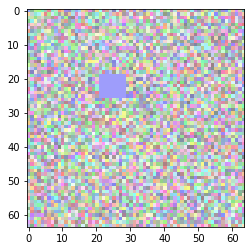

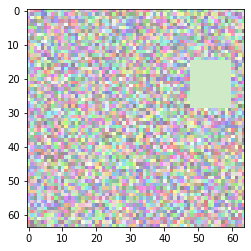

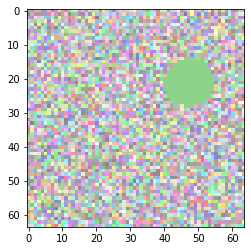

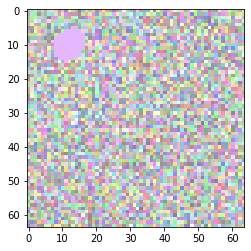

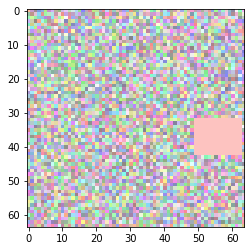

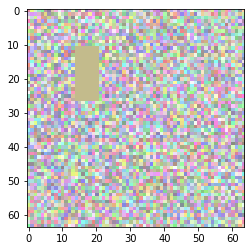

In [ ]:
print(targets.shape)
print(images.shape)
print(targets[:10])

#show the first 4 images#
for i in range(6):
  plt.imshow(images[i])
  plt.show()

if withBB:
  print(boundingBoxes.shape)
  print(boundingBoxes[:4])
  

In [ ]:
#QUESTION# What are the tensors now corresponding to "X" and "y" (with previous lecture notation) ?
if withBB :
    labels=[targets,boundingBoxes] 
else:
    labels=targets



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 62, 62, 7)    196         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 31, 31, 7)    0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 29, 29, 7)    448         max_pooling2d_6[0][0]            
_______________________________________________________________________________________

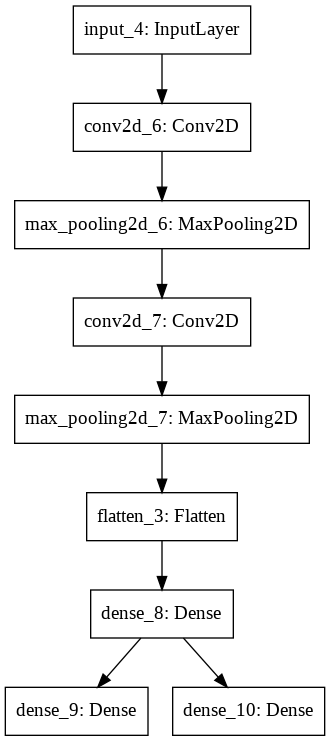

In [ ]:
inputs = Input(shape=(64, 64, 3))
conv = Conv2D(7, (3,3), activation='relu')(inputs)
pool = MaxPooling2D((2,2))(conv)
conv = Conv2D(7, (3,3), activation='relu')(pool)
pool = MaxPooling2D((3,3))(conv)
flatten = Flatten()(pool)
dense = Dense(20, activation='relu')(flatten)

#FILL ME# now let's try to decide the output layer, the activation and the loss based on the problem we have 
if simple : 
  outputs = Dense(1, activation='sigmoid')(dense) #FILLME# what is the output shape in this case? which activation?
  loss="binary_crossentropy"

if mixed : 
  outputs = Dense(2, activation='linear')(dense)
  loss='MSE'

if withBB : #In this case we have two separate output layers, two target tensors, two losses
  output1 = Dense(1, activation='sigmoid')(dense) #FILLME# which activation for the circle vs rectangle classification? 
  output2 = Dense(4, activation='linear')(dense) #FILLME# which activation to predict the 4 numbers of the bounding box ?
  outputs=[output1,output2]
  loss=["binary_crossentropy","MSE"] #FILL ME # And which loss for each of the two outputs? (the final loss will be the sum unless we give them some additional weights)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])

model.summary()


plot_model(model)

And now let's fit it to our data.
The sample is automatically split in 
two so that 50% of it is used for validation and the other half for training


In [ ]:
history=model.fit(images, labels, validation_split=0.5, epochs=50, verbose=0) 

*history* contains information about the training.  We can now now show the loss vs epoch for both validation and training samples.




dict_keys(['loss', 'dense_9_loss', 'dense_10_loss', 'dense_9_accuracy', 'dense_10_accuracy', 'val_loss', 'val_dense_9_loss', 'val_dense_10_loss', 'val_dense_9_accuracy', 'val_dense_10_accuracy'])


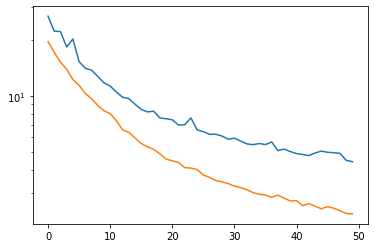

In [ ]:
print(history.history.keys())
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

#plt.plot(history.history["val_accuracy"])
#plt.plot(history.history["accuracy"])
#plt.show()


Let's try to create a new image and evaluate it

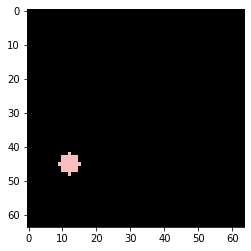

14.232087135314941 27.54049301147461 24.40612030029297 38.69691848754883
It is a circle


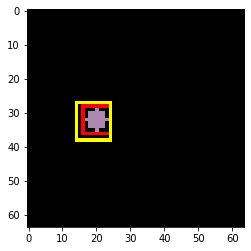

In [ ]:
image = genCircle()[0]
plt.imshow(image)
plt.show()

sample = np.reshape(image, (1, 64, 64, 3))

if mixed :
  im= genCircle()[0]+genRectangle()[0]+genRectangle()[0]
  sample = np.reshape(im, (1, 64, 64, 3))
  #FILL ME#try predicting on the "im" generated above... how do we access the number of predicted objects?
  #print("In this image there are %s rectangle and %s circles"%(....,....))
  plt.imshow(im)
  plt.show()

if withBB:
  im,x1,y1,x2,y2= genCircle()
  pre=model.predict(np.expand_dims(im,axis=0) )
  isCircle=pre[0][0]
  x1p=pre[1][0][0]-1.
  y1p=pre[1][0][1]-1.
  x2p=pre[1][0][2]+1.
  y2p=pre[1][0][3]+1.
  print(x1p,y1p,x2p,y2p)
  #print("Looks like a", ("circle" if model.predict(np.expand_dims(im,axis=0) )[0,1] > 0.5 else "rectangle"))
  print("It is a","circle" if isCircle > 0.5 else "rectangle" )
  cv2.rectangle(im,(x1-1,y1-1),(x2+1,y2+1), (255,0,0), 1)
  cv2.rectangle(im,(int(x1p),int(y1p)),(int(x2p),int(y2p)), (255,255,0), 1)
  plt.imshow(im)
  plt.show()

